In [2]:
# =====================================
# PART 1: IMPORT LIBRARIES
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

import joblib

In [3]:
# =====================================
# PART 2: LOAD DATA
# =====================================

df = pd.read_csv("./data/dynamic_record_gesture.csv")

print("\n===== DATA PREVIEW =====")
print(df.head())

print("\n===== DATA INFO =====")
print(df.info())

print("\n===== MISSING VALUES =====")
print(df.isnull().sum())

print("\n===== BASIC STATISTICS =====")
print(df.describe())



===== DATA PREVIEW =====
   id gesture_name  timestamp    ax    ay    az    gx    gy    gz    p0    p1  \
0   1         idle    1066413  0.01 -0.04  0.82 -0.42  0.41  0.16  4095  4095   
1   1         idle    1066425  0.02 -0.05  0.82  0.12  0.39  0.06  4095  4095   
2   1         idle    1066437  0.03 -0.03  0.81 -0.25  0.17 -0.25  4095  4095   
3   1         idle    1066449  0.04 -0.02  0.84  0.15  0.36  0.12  4095  4095   
4   1         idle    1066461  0.03 -0.02  0.83  0.25  0.10 -0.25  4095  4095   

     p2    p3  
0  4095  4095  
1  4095  4095  
2  4095  4095  
3  4095  4095  
4  4095  4095  

===== DATA INFO =====
<class 'pandas.DataFrame'>
RangeIndex: 2361 entries, 0 to 2360
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2361 non-null   int64  
 1   gesture_name  2361 non-null   str    
 2   timestamp     2361 non-null   int64  
 3   ax            2361 non-null   float64
 4   ay       


===== LABEL DISTRIBUTION =====
label
1    675
4    507
3    506
2    504
0    169
Name: count, dtype: int64


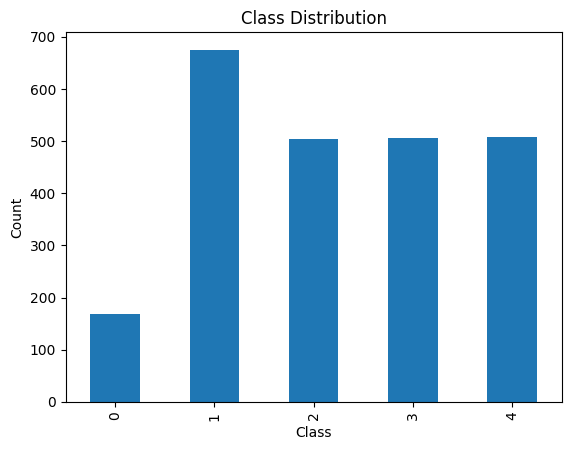

In [4]:
# =====================================
# PART 3: LABEL ENCODING
# =====================================

label_map = {
    "idle": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4
}

df["label"] = df["gesture_name"].map(label_map)

print("\n===== LABEL DISTRIBUTION =====")
print(df["label"].value_counts())

plt.figure()
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

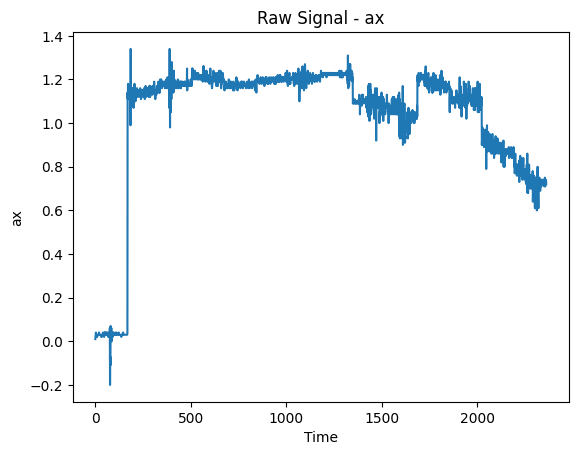

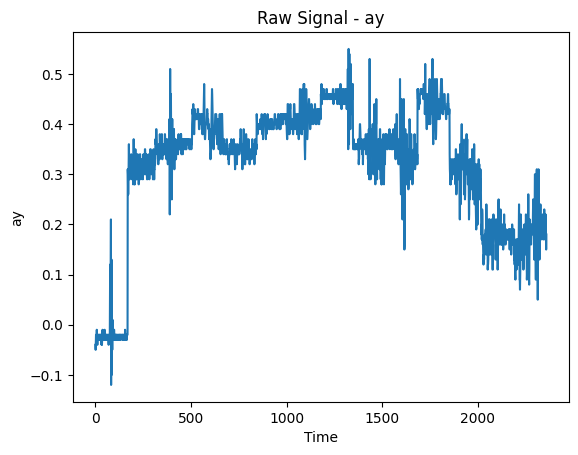

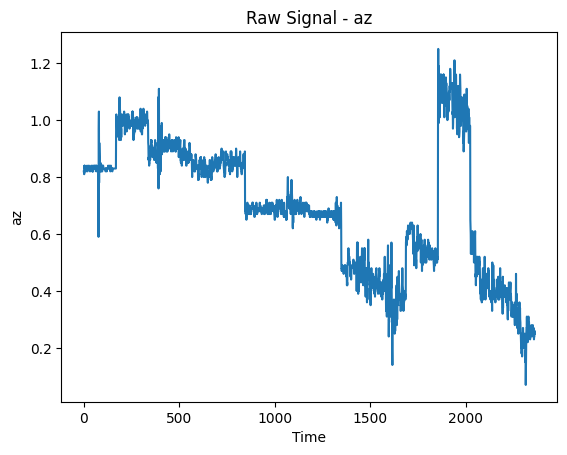

In [5]:
# =====================================
# PART 4: RAW SIGNAL VISUALIZATION
# =====================================

signals = ["ax","ay","az","gx","gy","gz","p0","p1","p2","p3"]

for col in signals[:3]:   # แสดง 3 ตัวแรก
    plt.figure()
    plt.plot(df[col].values)
    plt.title(f"Raw Signal - {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.show()


===== WINDOW DEBUG =====
Total windows: 87
Window shape: (50, 14)
Window label: 0


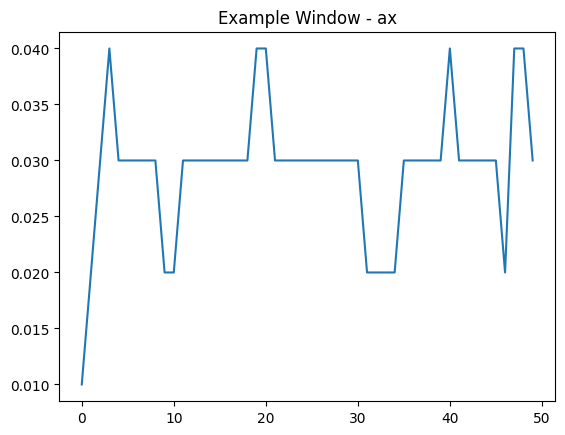

In [6]:
# =====================================
# PART 5: SLIDING WINDOW
# =====================================

WINDOW_SIZE = 50
STEP_SIZE = 25

def create_windows(df, window_size, step):
    windows = []
    labels = []

    for gesture_id in df["label"].unique():
        data = df[df["label"] == gesture_id]

        for start in range(0, len(data) - window_size, step):
            window = data.iloc[start:start+window_size]
            windows.append(window)
            labels.append(gesture_id)

    return windows, labels


windows, labels = create_windows(df, WINDOW_SIZE, STEP_SIZE)

print("\n===== WINDOW DEBUG =====")
print("Total windows:", len(windows))
print("Window shape:", windows[0].shape)
print("Window label:", labels[0])

plt.figure()
plt.plot(windows[0]["ax"].values)
plt.title("Example Window - ax")
plt.show()

In [7]:
# =====================================
# PART 6: FEATURE EXTRACTION
# =====================================

# -------------------------------------
# 1️⃣ Extract features function
# -------------------------------------

def extract_features(window):
    features = []
    signals = ["ax","ay","az","gx","gy","gz","p0","p1","p2","p3"]

    for col in signals:
        data = window[col].values

        features.append(np.mean(data))
        features.append(np.std(data))
        features.append(np.max(data))
        features.append(np.min(data))
        features.append(np.max(data) - np.min(data))  # range
        features.append(np.sqrt(np.mean(data**2)))    # RMS

    acc_mag = np.sqrt(window["ax"]**2 + window["ay"]**2 + window["az"]**2)
    gyro_mag = np.sqrt(window["gx"]**2 + window["gy"]**2 + window["gz"]**2)

    features.append(np.mean(acc_mag))
    features.append(np.mean(gyro_mag))

    return features


# -------------------------------------
# 2️⃣ Create Feature Names (62 features)
# -------------------------------------

signals = ["ax","ay","az","gx","gy","gz","p0","p1","p2","p3"]
stats = ["mean","std","max","min","range","rms"]

feature_names = []

for sig in signals:
    for stat in stats:
        feature_names.append(f"{stat}_{sig}")

feature_names.append("mean_acc_magnitude")
feature_names.append("mean_gyro_magnitude")

print("\n✓ Total feature names:", len(feature_names))


# -------------------------------------
# 3️⃣ Build Feature Matrix
# -------------------------------------

X = []
y = []

for window, label in zip(windows, labels):
    X.append(extract_features(window))
    y.append(label)

X = np.array(X)
y = np.array(y)

print("\n===== FEATURE MATRIX =====")
print("X shape:", X.shape)
print("y shape:", y.shape)

# ตรวจสอบ feature count ตรงไหม
assert X.shape[1] == len(feature_names), "❌ Feature mismatch!"
print("✓ Feature count matched (62)")


# -------------------------------------
# 4️⃣ Debug: ดูชื่อ feature + ค่า
# -------------------------------------

def explain_feature_vector(x, feature_names):
    print("\n===== FEATURE EXPLANATION =====\n")
    for i, (name, value) in enumerate(zip(feature_names, x)):
        print(f"{i:02d} | {name:25s} = {value:.6f}")

# แสดงตัวอย่าง window แรก
print("\nExample first 10 features:", X[0][:10])
explain_feature_vector(X[0], feature_names)


# -------------------------------------
# 5️⃣ Save feature names to file
# -------------------------------------

os.makedirs('./data/output_randomforest', exist_ok=True)

with open('./data/output_randomforest/selected_features.txt', 'w') as f:
    f.write("Selected Features:\n")
    f.write("="*50 + "\n\n")
    
    for i, feat in enumerate(feature_names, 1):
        f.write(f"{i}. {feat}\n")

print("\n✓ Saved: ./data/output_randomforest/selected_features.txt")


✓ Total feature names: 62

===== FEATURE MATRIX =====
X shape: (87, 62)
y shape: (87,)
✓ Feature count matched (62)

Example first 10 features: [ 0.0292      0.00594643  0.04        0.01        0.03        0.02979933
 -0.0242      0.00802247 -0.01       -0.05      ]

===== FEATURE EXPLANATION =====

00 | mean_ax                   = 0.029200
01 | std_ax                    = 0.005946
02 | max_ax                    = 0.040000
03 | min_ax                    = 0.010000
04 | range_ax                  = 0.030000
05 | rms_ax                    = 0.029799
06 | mean_ay                   = -0.024200
07 | std_ay                    = 0.008022
08 | max_ay                    = -0.010000
09 | min_ay                    = -0.050000
10 | range_ay                  = 0.040000
11 | rms_ay                    = 0.025495
12 | mean_az                   = 0.828800
13 | std_az                    = 0.006524
14 | max_az                    = 0.840000
15 | min_az                    = 0.810000
16 | range_az          

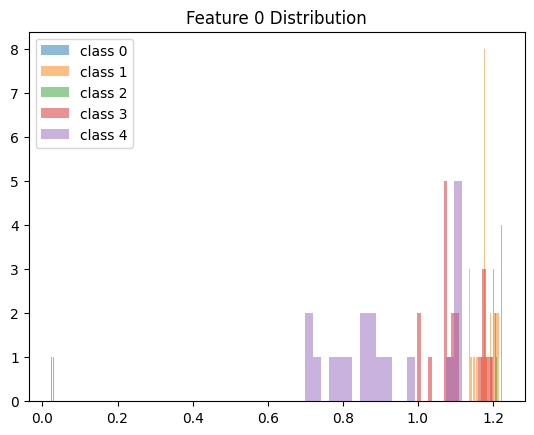

In [11]:
# =====================================
# PART 7: FEATURE DISTRIBUTION
# =====================================

plt.figure()
for label in np.unique(y):
    plt.hist(X[y==label, 0], bins=20, alpha=0.5, label=f"class {label}")

plt.legend()
plt.title("Feature 0 Distribution")
plt.show()

In [8]:
# =====================================
# PART 8: TRAIN TEST SPLIT
# =====================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (69, 62)
Test shape: (18, 62)


In [9]:
# =====================================
# PART 9: TRAIN MODEL
# =====================================

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Train Accuracy: 1.0
Test Accuracy: 1.0



Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



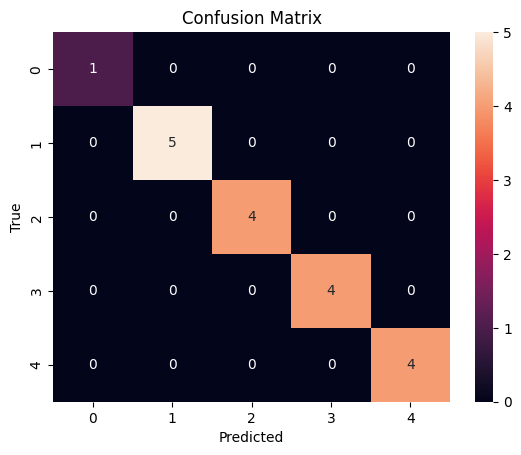

In [10]:
# =====================================
# PART 10: EVALUATION
# =====================================

y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

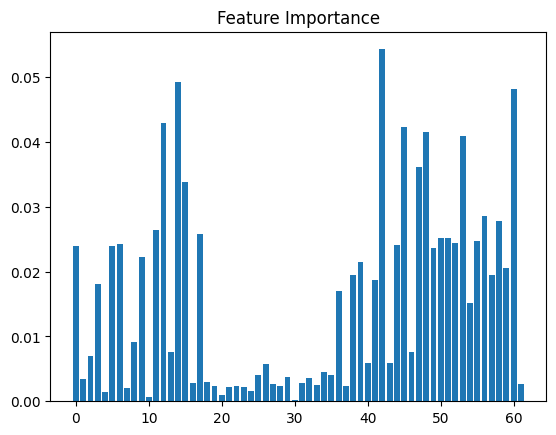


Top 10 Important Features:
Feature 42: 0.05433113969394318
Feature 14: 0.04929636194902043
Feature 60: 0.048228603302543034
Feature 12: 0.04288099980203375
Feature 45: 0.04228645810181488
Feature 48: 0.04158735197829218
Feature 53: 0.040907111616860684
Feature 47: 0.03618842621543471
Feature 15: 0.033834053212563414
Feature 56: 0.028587959275985293


In [11]:
# =====================================
# PART 11: FEATURE IMPORTANCE
# =====================================

importances = model.feature_importances_

plt.figure()
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.show()

indices = np.argsort(importances)[::-1][:10]

print("\nTop 10 Important Features:")
for i in indices:
    print(f"Feature {i}: {importances[i]}")

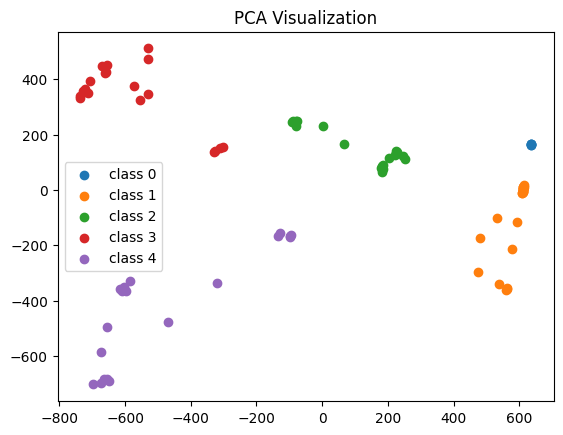

In [12]:
# =====================================
# PART 12: PCA VISUALIZATION
# =====================================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure()
for label in np.unique(y):
    plt.scatter(
        X_pca[y==label, 0],
        X_pca[y==label, 1],
        label=f"class {label}"
    )

plt.legend()
plt.title("PCA Visualization")
plt.show()

In [13]:
# =====================================
# PART 13: SAVE MODEL
# =====================================

joblib.dump(model, "./models/randomforest_model.pkl")
print("Model saved successfully.")

Model saved successfully.


In [19]:
print(X.shape)

(87, 62)
